In [3]:
import ast
import json
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import string
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer

Loading in initial dataset

In [2]:
def parseFile(fname):
    for l in open(fname, 'r', encoding='utf8'):
        yield ast.literal_eval(l)

In [3]:
data = list(parseFile('yelp_reviews.json'))

In [4]:
print("Size of initial dataset", len(data))

Size of initial dataset 5996996


Creating a new dataset using 150,000 random data points

In [5]:
random.shuffle(data)

In [6]:
new_data = data[:175000]

In [7]:
with open('data_final.json', 'w') as f:
    json.dump(new_data, f)

In [4]:
def parseFile2(fname):
    for l in open(fname):
        yield ast.literal_eval(l)

In [5]:
datum = list(parseFile2('data_final.json'))[0]

In [6]:
print("Size of new dataset", len(datum))

Size of new dataset 175000


In [7]:
len(datum)

175000

Split data into training, testing and validation 

In [8]:
random.shuffle(datum)
training = datum[:100000]
validation = datum[100000:150000]
testing = datum[150000:]

Visualise if cool, funny and useful affect star rating

In [13]:
funny = []
cool = []
useful = []
rating = []
for d in training:
    cool.append(d['cool'])
    funny.append(d['funny'])
    useful.append(d['useful'])
    rating.append(d['stars'])

In [14]:
print(len(cool), len(funny), len(useful), len(rating))

100000 100000 100000 100000


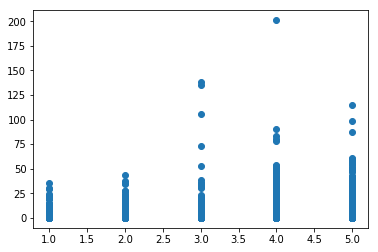

In [15]:
plt.scatter(rating, cool)

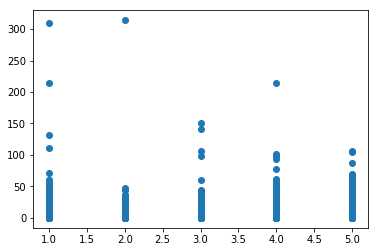

In [16]:
plt.scatter(rating, useful)

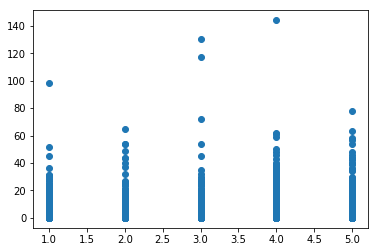

In [17]:
plt.scatter(rating, funny)

Remove date and other features that do not affect star rating 

In [18]:
for d in training:
    del d['date']
    del d['funny']
    del d['review_id']

In [19]:
for d in validation:
    del d['date']
    del d['funny']
    del d['review_id']

Create dictionary for all the users and a dictionary for all the restaurants

In [36]:
users = defaultdict(tuple)
restaurants = defaultdict(tuple)
for d in datum:
    user, business = d['user_id'], d['business_id']
    text, cool, useful, stars = d['text'], d['cool'], d['useful'], d['stars']
    users[user] += (stars, text, cool, useful, business)
    restaurants[business] += (stars, text, cool, useful, user)

In [37]:
print('number of restaurants: ', len(restaurants), " number of users: ",len(users))

number of restaurants:  65288  number of users:  132483


Create baseline using the overall average ratings of all restaurants

In [22]:
totalStars = 0
for values in restaurants.values():
    totalStars += values[3]
avgRating = round(totalStars / len(restaurants))
print(avgRating)

4


Accuracy of this baseline on the validation set:

In [23]:
pred = [avgRating for i in validation]
y = [i['stars'] for i in validation]
print(len(pred), len(y))

50000 50000


In [24]:
score = []
for i in range(len(pred)):
    if pred[i] == y[i]:
        score.append(1)
    else:
        score.append(0)
acc = sum(score) / len(score)
print('The accuracy of this baseline is: ', acc)

The accuracy of this baseline is:  0.21972


Create a baseline using the most common rating

In [25]:
ratingMap = defaultdict(int)
for d in training:
    if d['stars'] == 0:
        ratingMap[0] += 1
    elif d['stars'] == 1:
        ratingMap[1] += 1
    elif d['stars'] == 2:
        ratingMap[2] += 1
    elif d['stars'] == 3:
        ratingMap[3] += 1
    elif d['stars'] == 4:
        ratingMap[4] += 1
    elif d['stars'] == 5:
        ratingMap[5] += 1
most_common = sorted(ratingMap, key=ratingMap.get, reverse=True)[0]
most_common

5

Accuracy of this baseline on the validation set:

In [26]:
pred = [most_common for i in validation]
y = [d['stars'] for d in validation]
print(len(y), len(pred))

50000 50000


In [27]:
score = []
for i in range(len(pred)):
    if pred[i] == y[i]:
        score.append(1)
    else:
        score.append(0)
acc = sum(score) / len(score)
print('The accuracy of this baseline is: ', acc)

The accuracy of this baseline is:  0.44356


Create a list of the most popular restaurants and users

In [9]:
#retrain the baseline on just the new train data
businessCount = defaultdict(int)
userCount = defaultdict(int)
totalPurchases = 0

#item pop:
for tup in training:
    item = tup['business_id']
    user = tup['user_id']
    businessCount[item] += 1
    userCount[user] += 1
    totalPurchases += 1

mostPopular = [(businessCount[x], x) for x in businessCount]
mostPopular.sort()
mostPopular.reverse()

return1 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return1.add(i)
    if count > totalPurchases/2: break
        
mostPopular = [(userCount[x], x) for x in userCount]
mostPopular.sort()
mostPopular.reverse()

return2 = set()
count = 0
for ic, i in mostPopular:
    count += ic
    return2.add(i)
    if count > totalPurchases/2: break

In [10]:
print(len(return1), len(return2))

7793 32046


Use frequent words to get a list of the 1000 most commonly occuring words

In [11]:
words_cat = defaultdict(list)
userCatCounts = defaultdict(list)

for d in training:
    star = d['stars']
    user = d['user_id']
    if user not in userCatCounts:
        userCatCounts[user] = [0, 0, 0, 0, 0, 0]
    if star == 1:
        words_cat[1].append(d)
        userCatCounts[user][1] += 1
    elif star == 2:
        words_cat[2].append(d)
        userCatCounts[user][2] += 1
    elif star == 3:
        words_cat[3].append(d)
        userCatCounts[user][3] += 1
    elif star == 4:
        words_cat[4].append(d)
        userCatCounts[user][4] += 1
    elif star == 5:
        words_cat[5].append(d)
        userCatCounts[user][5] += 1

In [12]:
def computeCounts(data):
    wc = defaultdict(int)
    punctuation = set(string.punctuation)
    for tup in data:
        r = ''.join([c for c in tup['text'].lower() if not c in punctuation])
        for w in r.split():
            wc[w] += 1
    return wc

def getTopWords(data):
    #get the 1000 most common words
    common = set(['a', 'and', 'but', 'from', 'to', 'on', 'for', 'the', 'of'])
    counts = [(data[w], w) for w in data]
    counts.sort()
    counts.reverse()
    words = [x for x in counts[:1000] if not x in common]
    return words

In [13]:
#preprocess the data and find the counts for each word.
wordCount = computeCounts(training)
commonWords = getTopWords(wordCount)

#find the frequency of these words in all reviews
total = 0
for tup in commonWords:
    total += tup[0]
freqWordsTotal = {}
for x in commonWords:
    freqWordsTotal[x[1]] = x[0] / total
    

In [14]:
# now we compute the same thing but for reviews in each of the 1, 2, 3, 4, 5 start category
catFreqs = defaultdict(dict)
for i in np.arange(1, 6):
    wc = computeCounts(words_cat[i])
    total = 0
    new_dict = {}
    for key, val in list(freqWordsTotal.items()):
        total += wc[key]
    for key, val in list(freqWordsTotal.items()):
        new_dict[key] = wc[key] / total
    catFreqs[i] = new_dict

In [15]:
temp_dict ={}
topWords = defaultdict(list)
for i in np.arange(1, 6):
    l = []
    for key, val in list(freqWordsTotal.items()):
        diff = catFreqs[i][key] - val
        l.append((diff, key))
    temp_dict[i] = l
for i in np.arange(1, 6):
    temp_dict[i].sort()
    temp_dict[i].reverse()
    for x in np.arange(300, 1000):
        topWords[i].append(temp_dict[i][x])

In [16]:
finalWords = []
for val in topWords.values():
    finalWords.extend(val)

In [17]:
final_words_set = set(finalWords)
print(len(final_words_set))

3500


In [18]:
final_words_set

{(-6.984620689669994e-05, 'helped'),
 (-4.977221042072084e-05, 'knew'),
 (2.358081410219027e-06, 'tender'),
 (2.8259107231391316e-05, 'cup'),
 (-8.579447613166376e-05, 'leave'),
 (-0.000255906417365311, 'dessert'),
 (1.0944361944318086e-05, 'wine'),
 (-1.3629170809855546e-05, 'sell'),
 (-1.1124604280889918e-06, 'picked'),
 (1.340556631256425e-05, 'honestly'),
 (-2.0442993817377858e-05, 'seeing'),
 (-5.527119984045204e-05, 'fact'),
 (-0.00023278095981051354, 'well'),
 (-7.417416069426181e-05, 'worth'),
 (-2.6554251494275306e-05, 'run'),
 (-2.4987250818813252e-05, 'beers'),
 (-1.326764396076467e-05, 'crust'),
 (-0.00032213664793342707, 'still'),
 (6.606682297680876e-06, 'lamb'),
 (-4.472031883944644e-05, 'simply'),
 (-0.00010918453999586435, 'outstanding'),
 (1.3142662592618255e-06, 'toronto'),
 (-0.00014169951069952484, 'finally'),
 (2.4992139058593166e-05, 'run'),
 (8.94217320810748e-06, 'bring'),
 (-0.00023682340463516624, 'had'),
 (-0.00035519741275756925, 'us'),
 (-0.000104414195766

Get features

In [81]:
X = []
y = []
for d in training:
    y.append(d['stars'])
    feat = [x[1] in d['text'] for x in final_words_set]
#     feat.extend(userCatCounts[d['user_id']])
    feat.append(d['cool'])
    feat.append(d['useful'])
    feat.append(d['funny'])
    feat.append(d['user_id'] in return2)
    feat.append(d['business_id'] in return1)
    X.append(feat)
print(len(X), len(y))

100000 100000


In [82]:
X_valid = []
y_valid = []
for d in validation:
    y_valid.append(d['stars'])
    feat = [x[1] in d['text'] for x in final_words_set]
#     if d['user_id'] not in userCatCounts:
#         feat.extend([0, 0, 0, 0, 0, 0])
#     else:
#         feat.extend(userCatCounts[d['user_id']])
    feat.append(d['cool'])
    feat.append(d['useful'])
    feat.append(d['funny'])
    feat.append(d['user_id'] in return2)
    feat.append(d['business_id'] in return1)
    X_valid.append(feat)
print(len(X_valid), len(y_valid))

50000 50000


In [83]:
X_test = []
y_test = []
for d in testing:
    y_test.append(d['stars'])
    feat = [x[1] in d['text'] for x in final_words_set]
#     if d['user_id'] not in userCatCounts:
#         feat.extend([0, 0, 0, 0, 0, 0])
#     else:
#         feat.extend(userCatCounts[d['user_id']])
    feat.append(d['cool'])
    feat.append(d['useful'])
    feat.append(d['funny'])
    feat.append(d['user_id'] in return2)
    feat.append(d['business_id'] in return1)
    X_test.append(feat)
print(len(X_test), len(y_test))

25000 25000


Run model on a classifier

In [25]:
clf0 = svm.LinearSVC(C=0.01, multi_class='ovr', dual=False)
clf0.fit(X_valid, y_valid)
clf1 = svm.LinearSVC(C=0.1, multi_class='ovr', dual=False)
clf1.fit(X_valid, y_valid)
clf2 = svm.LinearSVC(C=1, multi_class='ovr', dual=False)
clf2.fit(X_valid, y_valid)
clf3 = svm.LinearSVC(C=10, multi_class='ovr', dual=False)
clf3.fit(X_valid, y_valid)
clf4 = svm.LinearSVC(C=100, multi_class='ovr', dual=False)
clf4.fit(X_valid, y_valid)

LinearSVC(C=100, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [27]:
print(clf0.score(X, y))
print(clf1.score(X, y))
print(clf2.score(X, y))
print(clf3.score(X, y))
print(clf4.score(X, y))

0.62398
0.62355
0.62354
0.62348
0.62353


In [28]:
print(clf0.score(X_valid, y_valid))
print(clf1.score(X_valid, y_valid))
print(clf2.score(X_valid, y_valid))
print(clf3.score(X_valid, y_valid))
print(clf4.score(X_valid, y_valid))

0.65176
0.65204
0.65222
0.65212
0.65218


In [29]:
print(clf0.score(X_test, y_test))
print(clf1.score(X_test, y_test))
print(clf2.score(X_test, y_test))
print(clf3.score(X_test, y_test))
print(clf4.score(X_test, y_test))

0.62064
0.61992
0.6202
0.62024
0.62024


train:<br>
0.62398
0.62355
0.62354
0.62348
0.62353
<br>
valid<br>
0.65176
0.65204
0.65222
0.65212
0.65218
<br>
test<br>
0.62064
0.61992
0.6202
0.62024
0.62024


Run Linear regression on features

In [38]:
theta, res, rank, s = np.linalg.lstsq(X, y, rcond=None)

LinAlgError: 0-dimensional array given. Array must be two-dimensional

In [172]:
def acc(data, theta, label):
    score = []
    for i in range(len(data)):
        prod = np.dot(data[i], theta).round()
        if prod == label[i]:
            score.append(1)
        else:
            score.append(0)
    return sum(score) / len(score)
acc(X, theta, y)

0.5581

In [173]:
acc(X_valid, theta, y_valid)

0.29718

accuracy without counts of each star ratings:<br>
    classification:<br>
        training: 0.64223<br>
        valid: 0.62768<br>
    regression:<br>
        training: 0.39779<br>
        valid: 0.39296<br>

accuracy with counts of each star ratings:<br>
    classification:<br>
        training: 0.92509<br>
        valid: 0.53912<br>
    regression:<br>
        training: 0.55329<br>
        valid: 0.30124<br>
      

accuracy with counts of each star ratings:<br>
    classification:<br>
        training: 0.9264<br>
        valid: 0.53912<br>
    regression:<br>
        training: 0.55329<br>
        valid: 0.30124<br>

In [151]:
usefulCount = defaultdict(int)
coolCount = defaultdict(int)
funnyCount = defaultdict(int)
for d in training:
    star = d['stars']
    if star == 1:
        usefulCount[1] += d['useful']
        coolCount[1] += d['cool']
        funnyCount[1] += d['funny']
    elif star == 2:
        usefulCount[2] += d['useful']
        coolCount[2] += d['cool']
        funnyCount[2] += d['funny']
    elif star == 3:
        usefulCount[3] += d['useful']
        coolCount[3] += d['cool']
        funnyCount[3] += d['funny']
    elif star == 4:
        usefulCount[4] += d['useful']
        coolCount[4] += d['cool']
        funnyCount[4] += d['funny']
    elif star == 5:
        usefulCount[5] += d['useful']
        coolCount[5] += d['cool']
        funnyCount[5] += d['funny']

In [156]:
funnyCount

defaultdict(int, {2: 5448, 5: 14333, 3: 6465, 1: 9919, 4: 12515})

Evaluate results 

In [46]:
xs, ys = [], []
for d in datum:
    ys.append(d['stars'])
    xs.append(d['text'])

In [47]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
vectors = vectorizer.fit_transform(xs)

In [48]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, ys, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [25]:
from sklearn.ensemble import RandomForestClassifier

E:\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [72]:
print(len(X_test), len(y_test))

25000 25000


In [49]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [50]:
clf.score(X_train, y_train)

0.9914464285714286

In [52]:
clf.score(X_val, y_val)

0.5251428571428571

In [53]:
clf.score(X_test, y_test)

0.5252285714285714

feat 4:<br>
training = 0.99169<br>
valid = 0.5247<br>
test = 0.52488<br>
feat 3:<br>
training = 0.99065<br>
valid = 0.52778<br>
test = 0.51772<br>
feat1:<br>
training = 0.99104<br>
valid = 0.52738<br>
test = 0.52096<br>

In [33]:
model = svm.LinearSVC(C=0.001)
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [34]:
model.score(X_train, y_train)

0.9978928571428571

In [35]:
model.score(X_test, y_test)

0.6715142857142857

In [36]:
model.score(X_val, y_val)

0.6749642857142857

In [37]:
from sklearn.metrics import accuracy_score
preds = model.predict(X_train)
print(accuracy_score(y_train, preds))

0.9978928571428571


In [44]:
documents = []
for d in training:
    documents.append(d['text'])

In [45]:
def idf(documents, word):
    alpha = 0.001
    top = len(documents) + alpha
    bot = alpha
    for d in documents:
        if word in d:
            bot += 1
    return np.log(top / bot)

def tf(document, word):
    freq = 0
    for w in document.split():
        if w == word:
            freq += 1
    return freq

def tf_idf(word, documents, document):
    return (tf(document, word) * idf(documents, word))

In [ ]:
X_train = []
y_train = []
for d in training:
    for w in d['text'].split():
        X_train.append(tf_idf(w, documents, d['text']))
    y_train.append(d['stars'])
print(len(X_train), len(y_train))

In [69]:
len(X_valid)

50000

In [30]:
from sklearn.neural_network import MLPClassifier

In [84]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20, 5), random_state=1)
clf.fit(X, y)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 5), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [85]:
clf.score(X, y)

0.60355

In [86]:
clf.score(X_valid, y_valid)

0.5984

In [87]:
clf.score(X_test, y_test)

0.59504

feat 4:<br>
training = 0.44102<br>
valid = 0.44106<br>
test = 0.44152<br>
feat 3:<br>
training = 0.43979<br>
valid = 0.44688<br>
test = 0.4348<br>
feat 1:<br>